In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='~/pytorch_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='~/pytorch_data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)


In [4]:
for batch_data, batch_labels in train_loader:
    print("Shape of a batch of data samples:", batch_data.shape)
    print("Shape of a batch of labels:", batch_labels.shape)
    break 

Shape of a batch of data samples: torch.Size([128, 1, 32, 32])
Shape of a batch of labels: torch.Size([128])


In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(96, 32, kernel_size=3, padding=1)

        # Output
        self.outconv = nn.Conv2d(32, 10, kernel_size=1) # The layer is essentially used to align the depth of the feature maps with the number of classes in the dataset. Each of the 10 output channels can be thought of as a 'score map' for one of the 10 classes.
        self.outdense = nn.Linear(10*32*32, 10)        
    def forward(self, x):
        # Encoder
        down1 = F.relu(self.conv1(x))
        down1p = self.pool(down1) 
        down2 = F.relu(self.conv2(down1p)) 
        down2p = self.pool(down2) 
        down3 = F.relu(self.conv3(down2p))
        down3p = self.pool(down3)  
        
        # Decoder
        up1 = F.relu(self.upconv1(down3p))
        up1 = torch.cat([up1,down2p], dim=1)
        up1 = F.relu(self.conv4(up1))
        up2 = F.relu(self.upconv2(up1))
        up2 = torch.cat([up2,down1p], dim=1)
        up2 = F.relu(self.conv5(up2))
        up3 = F.relu(self.upconv3(up2))
        up3 = torch.cat([up3,down1],dim=1)
        up3 = F.relu(self.conv6(up3))

        #Output

        outputs = F.relu(self.outconv(up3))
        outputs = outputs.view(outputs.size(0),-1)
        outputs = self.outdense(outputs)
        #return F.softmax(outputs, dim=1)
        return outputs

In [6]:
model = UNet()
model.to(device)

UNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv6): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (outconv): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
  (outdense): Linear(in_features=10240, out_features=10, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [8]:
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/10], Loss: 0.0017
Epoch [2/10], Loss: 0.0005
Epoch [3/10], Loss: 0.0003
Epoch [4/10], Loss: 0.0002
Epoch [5/10], Loss: 0.0002
Epoch [6/10], Loss: 0.0001
Epoch [7/10], Loss: 0.0001
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0001


In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 98.76%


Predicted: 4, Actual: 4


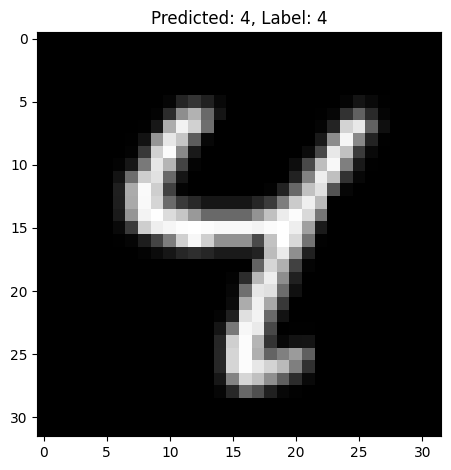

In [18]:
img, label = test_data[6]
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
if not isinstance(img, torch.Tensor):
    img = transform(img)

img = img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output.data, 1)

print(f"Predicted: {predicted.item()}, Actual: {label}")


if isinstance(img, torch.Tensor):
    img = img.squeeze().cpu().numpy()
else:
    img = np.array(img)


plt.imshow(img, cmap='gray')
plt.title(f"Predicted: {predicted.item()}, Label: {label}")
plt.tight_layout()
plt.show()